In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import product

In [2]:
data = pd.read_csv('Te dhena mbi konsumet 2013_2021 (1).csv')
data.head()

,Year,Month,Bought,Sold,NV,Lost
0,2013,January,735422368.7,712147000.0,403465.60,22871903.08
1,2013,February,657988856.3,640633717.3,347800.55,17007338.45
2,2013,March,663373030.9,649168952.2,357794.55,13846284.18
3,2013,April,533983791.4,519744979.3,255663.80,13983148.33
4,2013,May,493381739.3,481595212.5,196548.40,11589978.44


In [3]:
data['Date']=pd.to_datetime(data['Year'].astype(str) + '/' + data['Month '].astype(str) + '/01')

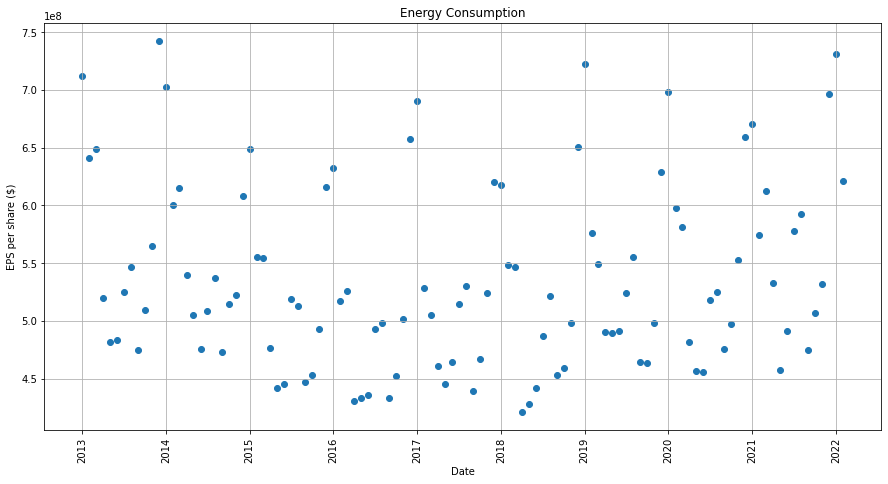

In [4]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.scatter(data['Date'], data['Sold '])
plt.title('Energy Consumption')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


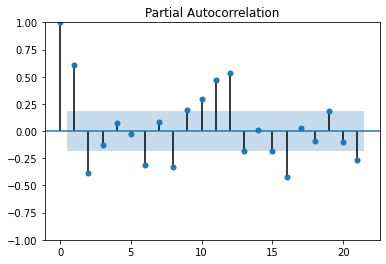

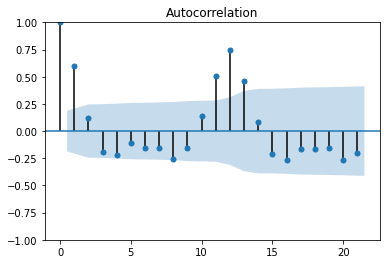

In [5]:
plot_pacf(data['Sold ']);
plot_acf(data['Sold ']);

In [6]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data['Sold '])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.0598685637328327
p-value: 0.7308077766757473


In [7]:
# Take the log difference to make data stationary

data['data'] = np.log(data['Sold '])
data['data'] = data['Sold '].diff()
data = data.drop(data.index[0])
data.head()

,Year,Month,Bought,Sold,NV,Lost,Date,data
1,2013,February,657988856.3,640633717.3,347800.55,17007338.45,2013-02-01,-71513282.7
2,2013,March,663373030.9,649168952.2,357794.55,13846284.18,2013-03-01,8535234.9
3,2013,April,533983791.4,519744979.3,255663.80,13983148.33,2013-04-01,-129423972.9
4,2013,May,493381739.3,481595212.5,196548.40,11589978.44,2013-05-01,-38149766.8
5,2013,June,499389420.7,483343094.4,186242.80,15819126.46,2013-06-01,1747881.9


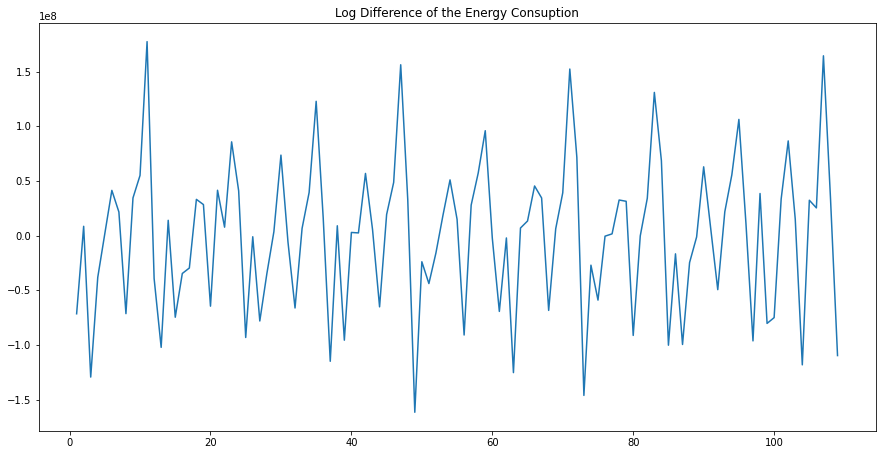

In [8]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of the Energy Consuption")
plt.show()

In [9]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.808548768167296
p-value: 0.05706297529910359


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


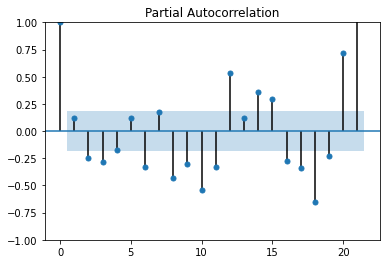

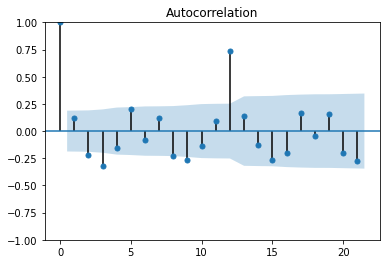

In [10]:
plot_pacf(data['data']);
plot_acf(data['data']);

In [11]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [12]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=data['data'])

result_df

<ipython-input-11-0c18f4fa5286>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Ver

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Ver

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p, d, q)",AIC
0,"(7, 1, 7)",4140.072406
1,"(6, 1, 5)",4143.767260
2,"(6, 1, 7)",4146.120922
3,"(7, 1, 6)",4148.974101
4,"(5, 1, 5)",4153.306797
...,...,...
59,"(5, 1, 0)",4219.831975
60,"(3, 1, 0)",4240.792300
61,"(2, 1, 0)",4251.801982
62,"(1, 1, 0)",4256.567043


In [13]:
best_model = SARIMAX(data['data'], order=(4,1,1)).fit()
print(best_model.summary())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                  109
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -2094.831
Date:                Sat, 22 Oct 2022   AIC                           4201.662
Time:                        14:25:55   BIC                           4217.755
Sample:                             0   HQIC                          4208.187
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0421      0.149      0.282      0.778      -0.251       0.335
ar.L2         -0.2302      0.124     -1.862      0.063      -0.473       0.012
ar.L3         -0.2731      0.128     -2.137      0.0

In [14]:
# Ljung-Box test and Augmented Dickey-Fuller test
ljung_box, p_value = acorr_ljungbox(best_model.resid)

print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: lb_stat
p-value: lb_pvalue


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


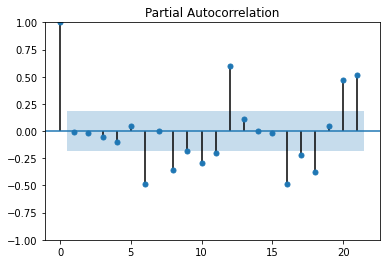

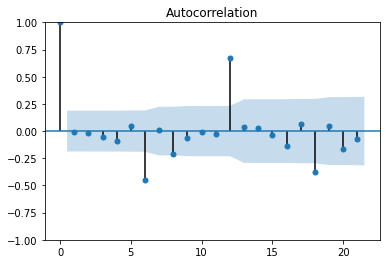

In [15]:
plot_pacf(best_model.resid);
plot_acf(best_model.resid);

SARIMA Model

In [16]:
data = pd.read_csv('/Users/maida/Desktop/isei/Te dhena mbi konsumet 2013_2021 (1).csv')
data.head()
# Seasonal differencing

data['data'] = data['Sold '].diff(4)
data = data.drop([0, 1, 2, 3, 4], axis=0).reset_index(drop=True)
data.head()

,Year,Month,Bought,Sold,NV,Lost,data
0,2013,June,499389420.7,483343094.4,186242.80,15819126.46,-157290622.9
1,2013,July,541294374.8,524752608.2,186976.80,16353993.75,-124416344.0
2,2013,August,563513387.7,546375801.8,199089.05,16938496.91,26630822.5
3,2013,September,489427703.2,474983619.1,194299.90,14249784.22,-6611593.4
4,2013,October,525995283.1,509500900.0,240461.50,16253921.63,26157805.6


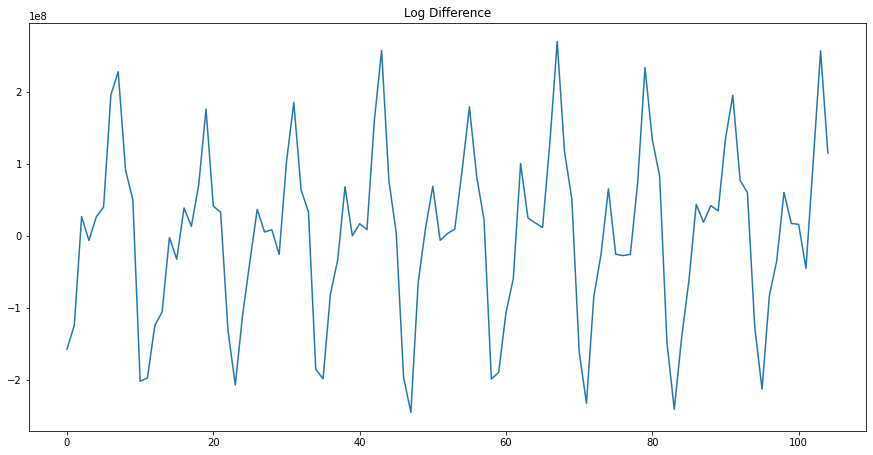

In [17]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference")
plt.show()

In [18]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.824189806433976
p-value: 0.05490064021977266


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


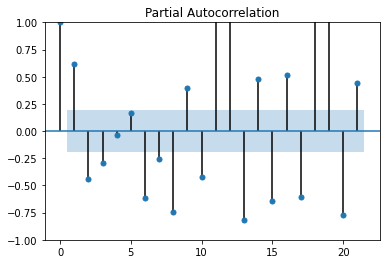

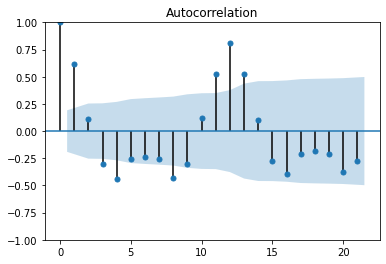

In [19]:
plot_pacf(data['data']);
plot_acf(data['data']);

In [20]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [21]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [22]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data['data'])
result_df

<ipython-input-20-1c6b5188e689>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  war

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)x(P,Q)",AIC
0,"(0, 0, 2, 3)",3848.602918
1,"(0, 0, 3, 3)",3853.204747
2,"(0, 0, 2, 2)",3867.886834
3,"(0, 0, 3, 1)",3868.973250
4,"(0, 0, 2, 1)",3876.210152
...,...,...
251,"(1, 1, 0, 0)",4069.869673
252,"(0, 1, 0, 0)",4081.864674
253,"(1, 0, 0, 0)",4081.910280
254,"(0, 0, 0, 0)",4082.634277


In [23]:
best_model = SARIMAX(data['data'], order=(0, 1, 2), seasonal_order=(0, 1, 2, 4)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              data   No. Observations:                  105
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 4)   Log Likelihood               -2002.638
Date:                           Sat, 22 Oct 2022   AIC                           4015.277
Time:                                   14:27:08   BIC                           4028.303
Sample:                                        0   HQIC                          4020.549
                                           - 105                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1134      0.562     -0.202      0.840      -1.214       0.987
ma.L2         -0.6616      0.927     -0.714

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.
  warnings.warn(


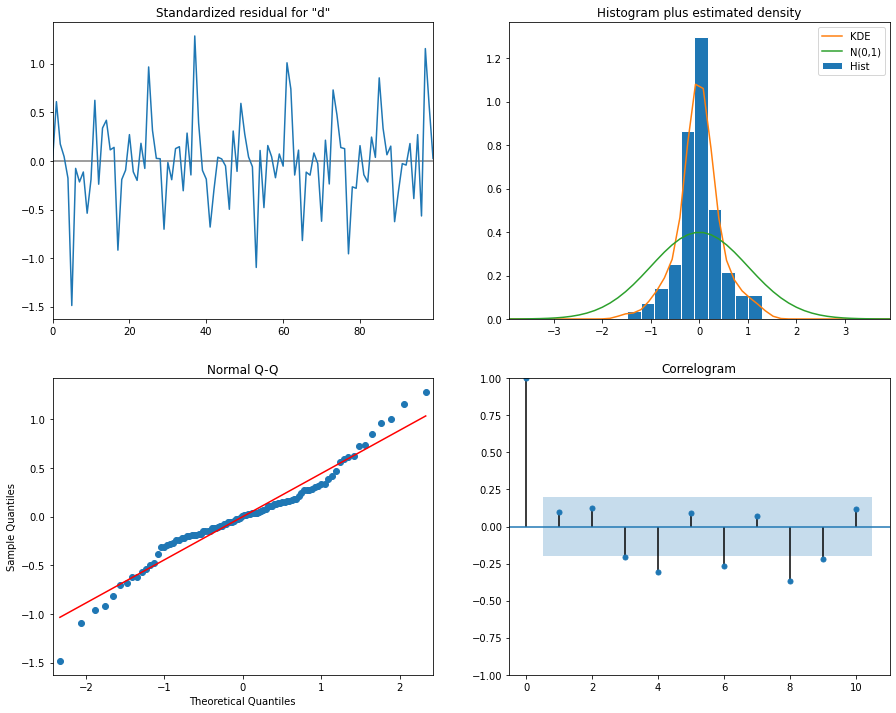

In [24]:
best_model.plot_diagnostics(figsize=(15,12));

<ipython-input-25-fa5bd32cfac2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['arima_model'][:4+1] = np.NaN


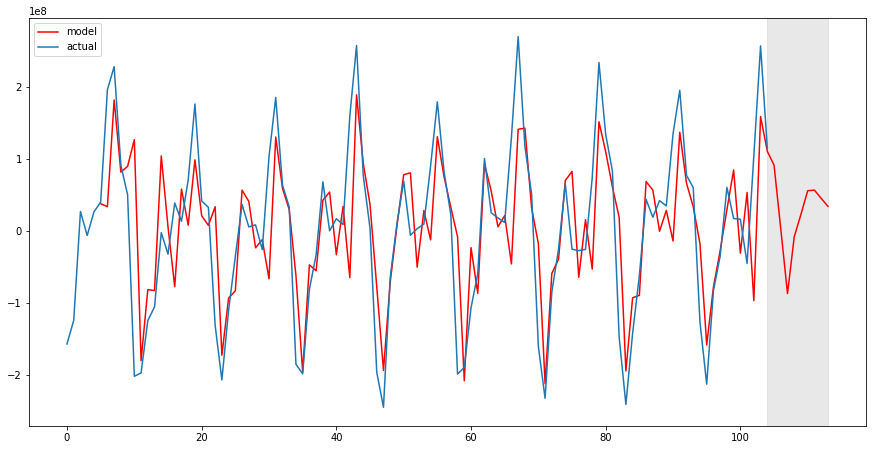

In [25]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN

forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 8)
forecast = data['arima_model'].append(forecast)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['data'], label='actual')
plt.legend()

plt.show()

NameError: name 'data' is not defined